# Algorithm Step-by-step

To contribute to the development of the algorithm, it's important to understand how `fast-vindex` works in order to improve the performance of the original `vindex` function.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

from dask.array.core import Array
from dask.highlevelgraph import HighLevelGraph
from dask.threaded import get
from dask._task_spec import Task, TaskRef, List
import numpy as np

from fast_vindex.testing import (
    generate_darray,
    DaskArray2D,
)

We start by generating a 2D Dask array that will serve as a reference for our indexing operations. Each value in the array is set to match its own coordinate, making it easy to visualize and verify the indexing behavior.

In [4]:
x = generate_darray(shape=(9, 9), chunks=(3, 3), fmt="dindices")

## Simple Case

### Step-by-Step

To understand how the new `vindex` implementation works, we’ll start with the simplest possible case. We will extract a subset from our Dask array using advanced (or "fancy") indexing.

In [5]:
indexes = (np.array([[1], [2], [3]]), np.array([[4, 5, 6]]))

This is the result we expect to obtain.

In [6]:
ref_arr = x.vindex[indexes].compute()
ref_arr

array([['(1, 4)', '(1, 5)', '(1, 6)'],
       ['(2, 4)', '(2, 5)', '(2, 6)'],
       ['(3, 4)', '(3, 5)', '(3, 6)']], dtype=object)

Alternatively, this extraction can be represented as follows.

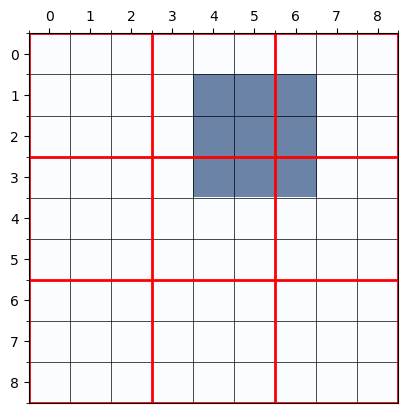

In [7]:
da2d = DaskArray2D(x)
da2d[indexes]

In the following, we directly provide the index already split by block. Naturally, one of the key challenges of the algorithm is to compute these sub-indices automatically.

In [8]:
# Shape of Output Blocks
shape = (3, 3)

# List of Block Coordinates in the Input Dask Array
in_blocks = [ 
    (0, 1),
    (0, 2),
    (1, 1),
    (1, 2), 
]

# List of Block Coordinates in the Output Dask Array
out_blocks = [
    (0, 0)
]

# List of Subset Indices within a Block of the Input Dask Array
in_indices = [
    ([[1], [2]], [[1, 2]]),
    ([[1], [2]], [[0]]),
    ([[0]], [[1, 2]]),
    ([[0]], [[0]]),
]

# List of Subset Indices within a Block of the Output Dask Array
out_indices = [
    ([[0], [1]], [[0, 1]]),
    ([[0], [1]], [[2]]),
    ([[2]], [[0, 1]]),
    ([[2]], [[2]]),
]

The concept of `in_indices` and `out_indices` can be tricky to visualize. It’s simply a matter of reference frame.

* `in_indices`: represent the indices of the parts we want to extract relative to the input block (the chunks).
* `out_indices`: represent the indices of the parts we want to extract relative to the output block (the result).

This can be visualized as follows:

In [9]:
idx = 0
da2d = DaskArray2D(x.blocks[*in_blocks[idx]])

Here is the representation of `in_indices`

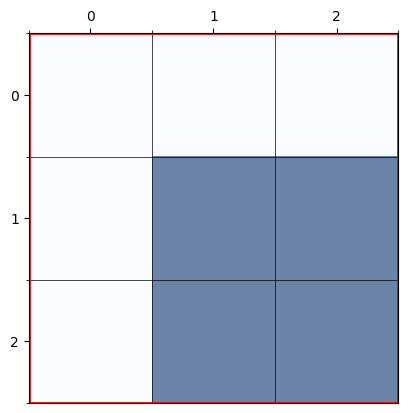

In [10]:
da2d[*in_indices[idx]] # Position of the subset within the input block

Here is the representation of `out_indices`

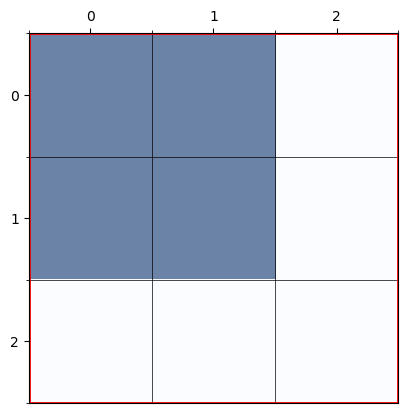

In [11]:
da2d[*out_indices[idx]] # Position of the subset within the output block

Now, the algorithm simply consists of extracting data from the input blocks at the `in_indices` positions and rewriting it at the `out_indices` positions within the output blocks.

In [12]:
def _vindex_slice(block, index):
    """Allows selecting a portion of a block based on an index."""
    block = block[index]
    return block

def _vindex_merge(shape, locations, values):
    """Allows merging multiple parts of a minicube according to their positions in the output blocks."""
    values = list(values)
    y = np.empty(shape, dtype=object)
    for loc, val in zip(locations, values):
        y[loc] = val
    return y

In [13]:
values = []
for i, (in_blk, in_idx) in enumerate(zip(in_blocks, in_indices)):

    value = _vindex_slice(x.blocks[*in_blk].compute(), in_idx)
    values.append(value)

arr = _vindex_merge(shape, out_indices, values)
arr

array([['(1, 4)', '(1, 5)', '(1, 6)'],
       ['(2, 4)', '(2, 5)', '(2, 6)'],
       ['(3, 4)', '(3, 5)', '(3, 6)']], dtype=object)

We can then verify if our algorithm worked by comparing the outputs.

In [14]:
np.array_equal(arr, ref_arr)

True

### Defining Lazy Tasks with Dask

After working through a simple case, we now look at how to package this logic into a task graph.

In [15]:
name = 'vindex-slice'
vindex_merge_name = "vindex-merge"

In [16]:
dsk = dict(x.dask) # {}
out_blk = out_blocks[0]
merge_inputs = defaultdict(list)
merge_indexer = defaultdict(list)

# SLICE
for i, (in_blk, in_indice, out_indice) in enumerate(zip(in_blocks, in_indices, out_indices)):
    k = (name, i)
    dsk[k] = Task(
        k,
        _vindex_slice,
        TaskRef((x.name,) + in_blk),
        in_indice,
    )

    merge_inputs[out_blk].append(TaskRef(k))
    merge_indexer[out_blk].append(out_indice)

In [17]:
get(dsk, ('vindex-slice', 0))

array([['(1, 4)', '(1, 5)'],
       ['(2, 4)', '(2, 5)']], dtype=object)

In [18]:
# MERGE
for i in merge_inputs.keys():
    k = (vindex_merge_name,) + i
    dsk[k] = Task(
        k,
        _vindex_merge,
        shape,
        merge_indexer[i],
        List(merge_inputs[i]),
    )

In [19]:
get(dsk, ('vindex-merge', 0, 0))

array([['(1, 4)', '(1, 5)', '(1, 6)'],
       ['(2, 4)', '(2, 5)', '(2, 6)'],
       ['(3, 4)', '(3, 5)', '(3, 6)']], dtype=object)

In [20]:
out_name = "vindex-merge"
arr = Array(
    HighLevelGraph.from_collections(out_name, dsk, dependencies=[x]),
    name=out_name,
    chunks=((3,),(3,)),
    dtype=x.dtype,
    meta=x._meta,
)
arr

dask.array<vindex, shape=(3, 3), dtype=object, chunksize=(3, 3), chunktype=numpy.ndarray>

In [21]:
arr.compute()

array([['(1, 4)', '(1, 5)', '(1, 6)'],
       ['(2, 4)', '(2, 5)', '(2, 6)'],
       ['(3, 4)', '(3, 5)', '(3, 6)']], dtype=object)

## Advanced Case

### Step-by-Step

In this more advanced case, here is the index we will be processing.

In [22]:
indexes = (np.array([[[1], [2], [3]], [[4], [5], [6]]]), np.array([[[4, 5, 6]], [[1, 2, 3]]]))

Here is the expected result.

In [23]:
ref_arr = x.vindex[indexes].compute()
ref_arr

array([[['(1, 4)', '(1, 5)', '(1, 6)'],
        ['(2, 4)', '(2, 5)', '(2, 6)'],
        ['(3, 4)', '(3, 5)', '(3, 6)']],

       [['(4, 1)', '(4, 2)', '(4, 3)'],
        ['(5, 1)', '(5, 2)', '(5, 3)'],
        ['(6, 1)', '(6, 2)', '(6, 3)']]], dtype=object)

This extraction can also be represented as follows.

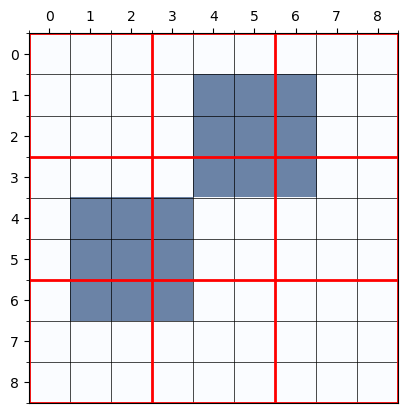

In [24]:
da2d = DaskArray2D(x)
da2d[indexes]

In [25]:
# Shape of Output Blocks
shape = (2, 3, 3)

# List of Block Coordinates in the Input Dask Array
in_blocks = [
    (0, 1),
    (0, 2), 
    (1, 1), 
    (1, 2),
    (1, 0),
    (1, 1), 
    (2, 0), 
    (2, 1),
]

# List of Block Coordinates in the Output Dask Array
out_blocks = [
    (0, 0, 0)
]

minicubes = [
    0, 0, 0, 0, 1, 1, 1, 1
]

# List of Subset Indices within a Block of the Input Dask Array
in_indices = [
    ([[1], [2]], [[1, 2]]),
    ([[1], [2]], [[0]]),
    ([[0]], [[1, 2]]),
    ([[0]], [[0]]),
    ([[1], [2]], [[1, 2]]),
    ([[1], [2]], [[0]]),
    ([[0]], [[1, 2]]),
    ([[0]], [[0]]),
]

# List of Subset Indices within a Block of the Output Dask Array
out_indices = [
    ([[0], [1]], [[0, 1]]),
    ([[0], [1]], [[2]]),
    ([[2]], [[0, 1]]),
    ([[2]], [[2]]),
    ([[0], [1]], [[0, 1]]),
    ([[0], [1]], [[2]]),
    ([[2]], [[0, 1]]),
    ([[2]], [[2]]),
]

In [26]:
def _vindex_slice(block, index):
    """Allows selecting a portion of a block based on an index."""
    block = block[index]
    return block

def _vindex_merge(shape, locations, values, minicubes):
    """Allows merging multiple parts of a minicube according to their positions in the output blocks."""
    values = list(values)
    y = np.empty(shape, dtype=object)
    for loc, val, mc in zip(locations, values, minicubes):
        y[mc][loc] = val
    return y

In [27]:
values = []
for i, (in_blk, in_idx) in enumerate(zip(in_blocks, in_indices)):

    value = _vindex_slice(x.blocks[*in_blk].compute(), in_idx)
    values.append(value)

arr = _vindex_merge(shape, out_indices, values, minicubes)
arr

array([[['(1, 4)', '(1, 5)', '(1, 6)'],
        ['(2, 4)', '(2, 5)', '(2, 6)'],
        ['(3, 4)', '(3, 5)', '(3, 6)']],

       [['(4, 1)', '(4, 2)', '(4, 3)'],
        ['(5, 1)', '(5, 2)', '(5, 3)'],
        ['(6, 1)', '(6, 2)', '(6, 3)']]], dtype=object)

In [28]:
np.array_equal(arr, ref_arr)

True

### Defining Lazy Tasks with Dask

In [29]:
name = 'vindex-slice'
vindex_merge_name = "vindex-merge"

In [30]:
dsk = {}
out_blk = out_blocks[0]
merge_inputs = defaultdict(list)
merge_indexer = defaultdict(list)
merge_minicube = defaultdict(list)

# SLICE
for i, (in_blk, in_indice, out_indice, minicube) in enumerate(zip(in_blocks, in_indices, out_indices, minicubes)):
    #k = (name,) + in_blk
    k = (name, i)
    dsk[k] = Task(
        k,
        _vindex_slice,
        TaskRef((x.name,) + in_blk),
        in_indice,
    )

    merge_inputs[out_blk].append(TaskRef(k))
    merge_indexer[out_blk].append(out_indice)
    merge_minicube[out_blk].append(minicube)

In [31]:
# MERGE
for i in merge_inputs.keys():
    k = (vindex_merge_name,) + i
    dsk[k] = Task(
        k,
        _vindex_merge,
        shape,
        merge_indexer[i],
        List(merge_inputs[i]),
        List(merge_minicube[i]),
    )

In [32]:
out_name = "vindex-merge"
arr = Array(
    HighLevelGraph.from_collections(out_name, dsk, dependencies=[x]),
    name=out_name,
    chunks=((2,),(3,),(3,)), 
    dtype=x.dtype,
    meta=x._meta,
)
arr

dask.array<vindex, shape=(2, 3, 3), dtype=object, chunksize=(2, 3, 3), chunktype=numpy.ndarray>

In [33]:
arr.compute()

array([[['(1, 4)', '(1, 5)', '(1, 6)'],
        ['(2, 4)', '(2, 5)', '(2, 6)'],
        ['(3, 4)', '(3, 5)', '(3, 6)']],

       [['(4, 1)', '(4, 2)', '(4, 3)'],
        ['(5, 1)', '(5, 2)', '(5, 3)'],
        ['(6, 1)', '(6, 2)', '(6, 3)']]], dtype=object)